In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras.callbacks import ModelCheckpoint
import os

Using TensorFlow backend.


In [2]:
#image dimensions
img_width, img_height = 200, 200

In [3]:
train_data_dir = './data/train'
val_data_dir  = './data/validation'
num_train_samples = 59850 #29925 in both classes  
num_val_samples  = 22828 #7498 in black, 15330 in death
epochs = 20 
batch_size = 32

In [4]:
if K.image_data_format() == 'channel_first':
    input_shape = (3, img_width, img_height)   #change 3 to 1 for grayscale
else:
    input_shape = (img_width, img_height, 3)

In [5]:

model = Sequential()
model.add(Conv2D(32, (3,3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [14]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [15]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='binary')

val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='binary')

#save the set weights with best validation loss
save_best_checkpoint = ModelCheckpoint('best_robnet.h5', save_best_only=True, save_weights_only=False, monitor='val_loss', mode='min')

Found 59849 images belonging to 2 classes.
Found 22828 images belonging to 2 classes.


In [7]:
if os.path.isfile('best_robnet.h5'):
    print('loading RobNet')
    model = load_model('best_robnet.h5') # retrain to get best_robnet_weights_rgb.h5
else:
    model.fit_generator(
        train_generator,
        steps_per_epoch=num_train_samples//batch_size,
        epochs=epochs,
        validation_data=val_generator,
        validation_steps=num_val_samples//batch_size,
        callbacks=[save_best_checkpoint])

#roughly 71% accuracy on rgb
#roughly 67% accuracy on greyscale

loading RobNet
Instructions for updating:
Use tf.cast instead.


# Lime decision interpretations

In [12]:
%pylab inline
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread


Populating the interactive namespace from numpy and matplotlib


/home/rcdc008/anaconda3/envs/mp/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['imread']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [13]:
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(200, 200))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        #x = inc_net.preprocess_input(x)
        out.append(x)
    return np.vstack(out)

(700, 700)


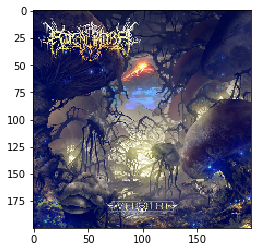

In [14]:
test_path = 'data/test/velothi_test.jpg'

from PIL import Image
im = Image.open(test_path)
print(im.size)
im = im.resize((200,200))
plt.imshow(im)
plt.show()

In [20]:
#images = transform_img_fn([os.path.join('data/actual_test','velothi_test.jpg')])
#plt.imshow(images[0]/255)
#plt.show()


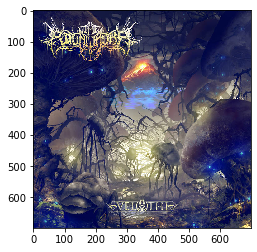

In [53]:
#img = mpimg.imread(test_path)
#imgplot = plt.imshow(img)
#plt.show()

In [58]:
npimg = np.array(im)
print(npimg.shape)
npimg = np.expand_dims(npimg, axis=0)
print(npimg.shape)

genre_mapping = {0: 'black', 1: 'death'}

preds = model.predict_classes(npimg)
pred_classes = [genre_mapping[pred[0]] for pred in preds]

print(pred_classes)

(200, 200, 3)
(1, 200, 200, 3)
[[0]]
['black']


In [60]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
explainer = lime_image.LimeImageExplainer()


In [91]:
#%%time
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(images[0], model.predict, top_labels=2, hide_color=0, num_samples=1000)
print(explanation)

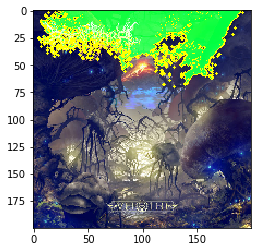

In [109]:
from skimage.segmentation import mark_boundaries

print(explanation)
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=50, hide_rest=False)
plt.imshow(mark_boundaries(temp/255, mask))